In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [3]:
df_rain = pd.read_csv("../data/processed/rain_processed_2023.csv")
df_rain.head(3)

,stno,yyyymmddhh,PP01,PP01_clean,PP01_accumulated,PP01_accumulated_window
0,C0A520,2023-12-01 00:00:00,0.5,0.5,False,False
1,C0A520,2023-12-01 01:00:00,0.5,0.5,False,False
2,C0A520,2023-12-01 02:00:00,1.0,1.0,False,False


## add longtitude + latitude

In [4]:
with open("../data/raw/station.json", "r", encoding="utf-8") as f:
    data = json.load(f)

stations = data["cwaopendata"]["dataset"]["Station"]
stations_loc = []

for st in stations:
    # ----- test -----
    # print(st)
    # print(st["StationId"])
    # print(st["GeoInfo"]["Coordinates"][1]["StationLatitude"])
    # print(st["GeoInfo"]["Coordinates"][1]["StationLongitude"])

    # ----- processing -----
    stations_loc.append({"stno": st["StationId"],
                         "lat": st["GeoInfo"]["Coordinates"][1]["StationLatitude"],
                         "lon": st["GeoInfo"]["Coordinates"][1]["StationLongitude"]})
    

In [5]:
stations_loc[0:5]

[{'stno': 'C1I230', 'lat': '23.962025', 'lon': '120.845272'},
 {'stno': '466940', 'lat': '25.133314', 'lon': '121.740475'},
 {'stno': '466900', 'lat': '25.164889', 'lon': '121.448906'},
 {'stno': '466881', 'lat': '24.959207', 'lon': '121.525196'},
 {'stno': '466930', 'lat': '25.162078', 'lon': '121.544547'}]

In [6]:
df_station = pd.DataFrame(stations_loc)
df_station.head(3)

,stno,lat,lon
0,C1I230,23.962025,120.845272
1,466940,25.133314,121.740475
2,466900,25.164889,121.448906


In [7]:
df_rain = pd.merge(df_rain, df_station, on="stno", how="left")

In [8]:
df_rain["lat"].isna().sum(), len(df_rain)

(62202, 469170)

In [9]:
df_rain.dropna(subset=["lat", "lon"], inplace=True)
len(df_rain)

406968

## compute Dec. rainfall

In [10]:
df_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406968 entries, 0 to 469169
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   stno                     406968 non-null  object 
 1   yyyymmddhh               406968 non-null  object 
 2   PP01                     406968 non-null  float64
 3   PP01_clean               396891 non-null  float64
 4   PP01_accumulated         406968 non-null  bool   
 5   PP01_accumulated_window  406968 non-null  bool   
 6   lat                      406968 non-null  object 
 7   lon                      406968 non-null  object 
dtypes: bool(2), float64(2), object(4)
memory usage: 22.5+ MB


In [11]:
df_rain["yyyymmddhh"] = pd.to_datetime(df_rain["yyyymmddhh"])
df_rain["lat"] = df_rain["lat"].astype(float)
df_rain["lon"] = df_rain["lon"].astype(float)

In [12]:
print(df_rain.info(), df_rain["PP01_clean"].describe(), "\n", df_rain["stno"].nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 406968 entries, 0 to 469169
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   stno                     406968 non-null  object        
 1   yyyymmddhh               406968 non-null  datetime64[ns]
 2   PP01                     406968 non-null  float64       
 3   PP01_clean               396891 non-null  float64       
 4   PP01_accumulated         406968 non-null  bool          
 5   PP01_accumulated_window  406968 non-null  bool          
 6   lat                      406968 non-null  float64       
 7   lon                      406968 non-null  float64       
dtypes: bool(2), datetime64[ns](1), float64(4), object(1)
memory usage: 22.5+ MB
None count    396891.000000
mean          0.097950
std           0.510511
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name:

In [13]:
df_rain_month = df_rain.groupby(["stno", "lat", "lon"], as_index=False)["PP01_clean"].sum()
df_rain_month.rename(columns={"PP01_clean": "rain_dec"}, inplace=True)

In [14]:
df_rain_month.head(3)

,stno,lat,lon,rain_dec
0,C0A520,24.974944,121.402008,103.0
1,C0A530,24.938183,121.709750,165.5
2,C0A550,24.971197,121.823711,538.0


## Construct the Grid (resolution: 2.5 km)

In [15]:
nx = 260
ny = 260
lon_min, lon_max = 117.43, 123.92
lat_min, lat_max = 20.76, 26.70
lon = np.linspace(lon_min, lon_max, nx)
lat = np.linspace(lat_min, lat_max, ny)
grid_lon, grid_lat = np.meshgrid(lon, lat)

## Estimate rainfall with Spherical Variogram + Simple Kriging

In [16]:
!pip install gstools


[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import gstools as gs

In [47]:
x = df_rain_month["lon"].to_numpy(dtype=float)
y = df_rain_month["lat"].to_numpy(dtype=float)
z = df_rain_month["rain_dec"].to_numpy(dtype=float)

m = 0.0
z_res = z - m

# bin_center: representative value of each bin (bin=20)
# gamma: estimate variogram of each interval
bin_center, gamma = gs.vario_estimate((x, y), z_res)

# initialize Spherical variogram model unknown parameter
sill_0 = np.nanvar(z_res)
range_0 = 0.25 * (bin_center.max() - bin_center.min())  
nug_0 = 1000

model = gs.Spherical(dim=2, var = sill_0, len_scale = range_0, nugget = nug_0)

# train model (LSE)
np.random.seed(123)
model.fit_variogram(bin_center, gamma, nugget=False, max_eval=20000)

# compute
sk = gs.krige.Simple(model, cond_pos=(x, y), cond_val=z_res, mean=0)
z_grid_res, var_grid = sk((grid_lon, grid_lat))
z_grid = z_grid_res + m

In [19]:
len(z_grid), len(grid_lat), len(grid_lon)

(67600, 260, 260)

In [20]:
z_grid_2d = z_grid.reshape(260, 260)
len(z_grid_2d)

260

In [48]:
sill_opt = model.var
range_opt = model.len_scale
nug_opt = model.nugget
print(sill_opt, range_opt, nug_opt)

10158.967379351423 1.8154642167385562 1000.0


## Visualization

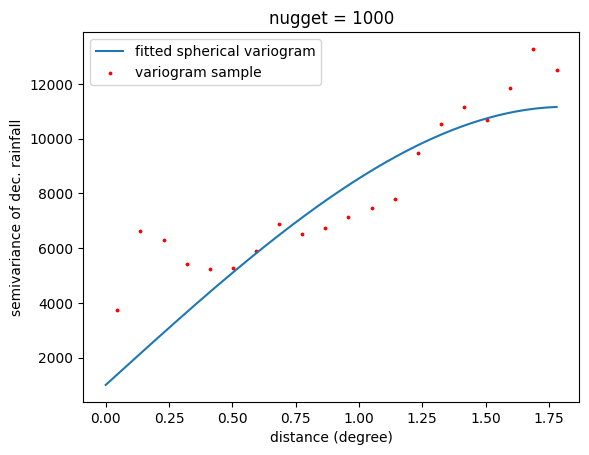

In [50]:
plt.figure()
h = np.linspace(0, bin_center.max(), 200)
gamma_fit = model.variogram(h)
plt.plot(h, gamma_fit)
plt.scatter(bin_center, gamma, c="red", s=3)

plt.title("nugget = 1000")
plt.xlabel("distance (degree)")
plt.ylabel("semivariance of dec. rainfall")
plt.legend(["fitted spherical variogram", "variogram sample"])

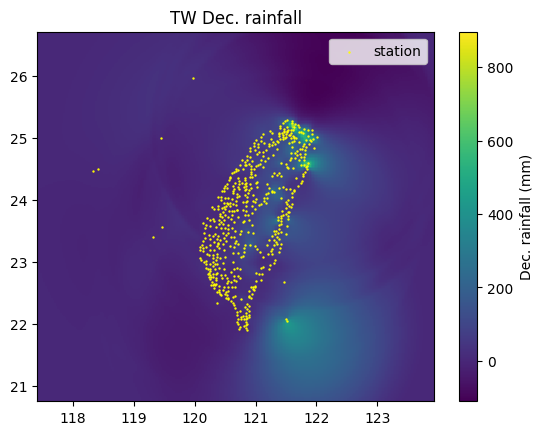

In [51]:
plt.figure()
plt.title("TW Dec. rainfall")

pcm = plt.pcolormesh(grid_lon, grid_lat, z_grid_2d)
cbar = plt.colorbar(pcm)
cbar.set_label("Dec. rainfall (mm)")

plt.scatter(x , y, s=0.5, c="yellow")
plt.legend(["station"])

### 12月雨量觀察
1. 北部與東北側 (迎東北季風)、蘭嶼雨量較高
2. 無高值出現於鄰近無測站情況

- 結果與地理常識大致相同
- 海上數據可透過遮罩方式消除